# データセットをPCAするパイプラインを作成する

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [1]:
from util.training.dataloader import split_data_for_single_location

2024-10-30 15:24:45.320532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-30 15:24:45.446112: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [66]:
def average_over_T_dimension(X):
    return np.mean(X, axis=1)

In [68]:
def apply_pca(X_train, X_valid, X_test, n_components):
    """
    Apply PCA to X_train, X_valid, and X_test along the (F, 2) feature dimensions.

    Parameters:
    X_train, X_valid, X_test (numpy.ndarray): Input datasets of shape (N, F, 2).
    n_components (int): Number of principal components to keep.

    Returns:
    tuple: X_train_pca, X_valid_pca, X_test_pca, transformed into shape (N, n_components).
    """
    # Reshape each dataset to 2D: (N, F*2)
    N_train, F, _ = X_train.shape
    X_train_reshaped = X_train.reshape(N_train, F * 2)
    N_valid, _, _ = X_valid.shape
    X_valid_reshaped = X_valid.reshape(N_valid, F * 2)
    N_test, _, _ = X_test.shape
    X_test_reshaped = X_test.reshape(N_test, F * 2)
    
    # Fit PCA on X_train and apply to all datasets
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_reshaped)
    X_valid_pca = pca.transform(X_valid_reshaped)
    X_test_pca = pca.transform(X_test_reshaped)
    
    return X_train_pca, X_valid_pca, X_test_pca

In [108]:
def stack_frames(data, window_size):
    """
    フレームをウィンドウサイズ分スタックし、新たな第3次元として追加する関数。
    
    Parameters:
    data (numpy.ndarray): 入力データ。形状は (フレーム, サブキャリア, 2)。
    window_size (int): フレームをスタックするウィンドウサイズ。
    
    Returns:
    numpy.ndarray: スタック後のデータ。形状は (フレーム数 - window_size + 1, サブキャリア, window_size, 2)。
    """
    # フレームをウィンドウサイズ分スライディングしながらスタック
    stacked_data = np.array([data[i:i+window_size] for i in range(data.shape[0] - window_size + 1)])
    
    # 形状を変換
    stacked_data = stacked_data.reshape(-1, data.shape[1], window_size)
    
    return stacked_data

In [114]:
def preprocess_pipeline(dataset, n_components, window_size):

    train_data, valid_data, test_data = dataset

    X_train, y_train = train_data
    X_valid, y_valid = valid_data
    X_test, y_test = test_data
    
    X_train_avg = average_over_T_dimension(X_train)
    X_valid_avg = average_over_T_dimension(X_valid)
    X_test_avg = average_over_T_dimension(X_test)

    X_train_pca, X_valid_pca, X_test_pca = apply_pca(X_train_avg, X_valid_avg, X_test_avg, n_components)
    variance_ratio = calculate_explained_variance(X_train_avg, n_components)
    print(f"{n_components} 個の主成分で維持される分散: {variance_ratio:.2f}%")

    X_train = stack_frames(X_train_pca, window_size)
    X_valid = stack_frames(X_valid_pca, window_size)
    X_test = stack_frames(X_test_pca, window_size)

    y_train = y_train[window_size-1:]
    y_valid = y_valid[window_size-1:]
    y_test = y_test[window_size-1:]

    train_data = X_train, y_train
    valid_data = X_valid, y_valid
    test_data = X_test, y_test

    return train_data, valid_data, test_data

In [74]:
def calculate_explained_variance(X, n_components):
    """
    Calculate the cumulative explained variance for a specified number of components.

    Parameters:
    X (numpy.ndarray): Input dataset of shape (N, F, 2).
    n_components (int): Number of principal components to retain.

    Returns:
    float: Cumulative explained variance ratio as a percentage.
    """
    # Reshape to 2D: (N, F*2)
    N, F, _ = X.shape
    X_reshaped = X.reshape(N, F * 2)
    
    # Fit PCA with the specified number of components
    pca = PCA(n_components=n_components)
    pca.fit(X_reshaped)
    
    # Calculate cumulative explained variance ratio
    cumulative_variance_ratio = np.sum(pca.explained_variance_ratio_) * 100  # Convert to percentage
    
    return cumulative_variance_ratio

In [99]:
csi_preprocess_id = 'real_and_imag'
location = '514B'
dataset = split_data_for_single_location(csi_preprocess_id, location, shuffle=False)

train_data, valid_data, test_data = dataset

X_train, y_train = train_data
X_valid, y_valid = valid_data
X_test, y_test = test_data

print(f'{X_train.shape=}, {X_valid.shape=}, {X_test.shape=}')

X_train.shape=(8400, 10, 52, 2), X_valid.shape=(1800, 10, 52, 2), X_test.shape=(1800, 10, 52, 2)


In [100]:
X_train_avg = average_over_T_dimension(X_train)
X_valid_avg = average_over_T_dimension(X_valid)
X_test_avg = average_over_T_dimension(X_test)

print(f'{X_train_avg.shape=}, {X_valid_avg.shape=}, {X_test_avg.shape=}')

X_train_avg.shape=(8400, 52, 2), X_valid_avg.shape=(1800, 52, 2), X_test_avg.shape=(1800, 52, 2)


<AxesSubplot: >

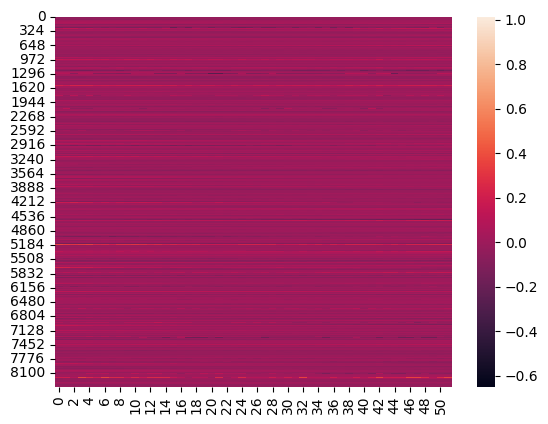

In [101]:
sns.heatmap(X_train_avg[:,:,0])

In [112]:
n_components = 10  # 主成分数を指定
X_train_pca, X_valid_pca, X_test_pca = apply_pca(X_train_avg, X_valid_avg, X_test_avg, n_components)

In [113]:
print(f'{X_train_pca.shape=}, {X_valid_pca.shape=}, {X_test_pca.shape=}')

X_train_pca.shape=(8400, 10), X_valid_pca.shape=(1800, 10), X_test_pca.shape=(1800, 10)


In [115]:
window_size = 10
dataset_pp = preprocess_pipeline(dataset, n_components, window_size)

10 個の主成分で維持される分散: 95.34%


In [116]:
train_data_pp, valid_data_pp, test_data_pp = dataset_pp
X_train_pp, y_train_pp = train_data_pp
X_valid_pp, y_valid_pp = valid_data_pp
X_test_pp, y_test_pp = test_data_pp

In [117]:
print(f'{X_train_pp.shape=}, {y_train_pp.shape=}')
print(f'{X_valid_pp.shape=}, {y_valid_pp.shape=}')
print(f'{X_test_pp.shape=}, {X_test_pp.shape=}')


X_train_pp.shape=(8391, 10, 10), y_train_pp.shape=(8391, 28, 28)
X_valid_pp.shape=(1791, 10, 10), y_valid_pp.shape=(1791, 28, 28)
X_test_pp.shape=(1791, 10, 10), X_test_pp.shape=(1791, 10, 10)
